In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from tensorflow.keras.datasets import mnist    
%matplotlib inline
import matplotlib.pyplot as plt  # 匯入繪圖函式庫
import Augmentor as aug
import numpy as np
import pandas as pd
from keras import models
from keras import layers
from keras.utils import to_categorical
from keras import backend as K
from keras.callbacks import EarlyStopping
from datetime import datetime
from keras.losses import sparse_categorical_crossentropy
import time


In [2]:
# 載入 MNIST 資料集
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


In [3]:
# 資料預處理
# 1. 將所有圖片像素值歸一化
train_img = train_images / 255
test_img = test_images / 255

# 2. 標籤資料進行 one-hot 編碼
train_lab = to_categorical(train_labels)
test_lab = to_categorical(test_labels)


In [4]:
# 計算方法封裝
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1_score = 2 * ((precision_value * recall_value) / (precision_value + recall_value + K.epsilon()))
    return f1_score

def plot_metrics_test(all_train_histories, model_names):
    markers = ['o', 's', '^', 'D', '*', 'P', 'X']  
    linestyles = ['-', '--'] 
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1_score']
    # 確定輸出目錄存在並創建以當前時間命名的資料夾
    output_dir = r'C:\Users\watch\Desktop\output\img'
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    output_dir = os.path.join(output_dir, current_time)
    os.makedirs(output_dir, exist_ok=True)
        
    for metric in metrics:
        plt.figure(figsize=(12, 6))
        for i, (train_history, model_name) in enumerate(zip(all_train_histories, model_names)):
            history = train_history.history
            metric_values = history.get(metric, [])
            val_metric_values = history.get(f'val_{metric}', [])
            epochs_range = range(1, len(metric_values) + 1)

            marker = markers[i % len(markers)]
            linestyle_train = linestyles[0]
            linestyle_val = linestyles[1]

            plt.plot(epochs_range, metric_values, linestyle_train, marker=marker, label=f'{model_name} Train', linewidth=2)
            plt.plot(epochs_range, val_metric_values, linestyle_val, marker=marker, label=f'{model_name} Validation', linewidth=2)

        plt.title(f'Train and Validation {metric.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        # 將圖片保存到以當前時間命名的資料夾中
        global export_data
        if export_data:
            plt.savefig(os.path.join(output_dir, f'{metric}.png'))
        plt.show()

    print("圖片已成功保存到指定目錄中")

In [5]:
def prepare_MLP_data():
    global train_img, train_lab, test_img, test_lab  # 聲明這些變量是全局的
    ## MLP 資料帶入
    mlp_train_img, mlp_train_lab = train_img, train_lab
    mlp_test_img, mlp_test_lab = test_img, test_lab
    ## MLP 資料處理
    train_img = mlp_train_img.reshape((mlp_train_img.shape[0], 28 * 28))
    test_img = mlp_test_img.reshape((mlp_test_img.shape[0], 28 * 28))


In [14]:
# 模型設定
mod_one_hidden_columns = ['model_name','nodes','activation_function','optimizer','batch_size']
Mod_Nodes_250 = ['Mod_Nodes_250', 250, 'relu', 'adam', 128]
Mod_Nodes_500 = ['Mod_Nodes_500', 500, 'relu', 'adam', 128]
Mod_Nodes_1000 = ['Mod_Nodes_1000', 1000, 'relu', 'adam', 128]
Mod_Nodes_1500 = ['Mod_Nodes_1500', 1500, 'relu', 'adam', 128]
Mod_Nodes_2000 = ['Mod_Nodes_2000', 2000, 'relu', 'adam', 128]
Mod_opt_adam = ['Mod_opt_adam', 1000, 'relu', 'adam', 128]
Mod_opt_rmsprop = ['Mod_opt_rmsprop', 1000, 'relu', 'rmsprop', 128]
Mod_opt_adagrad = ['Mod_opt_adagrad', 1000, 'relu', 'adagrad', 128]
Mod_act_relu = ['Mod_act_relu', 1000, 'relu', 'adam', 256]
Mod_act_sigmoid = ['Mod_act_sigmoid', 1000, 'sigmoid', 'adam', 256]
Mod_bat_64 = ['Mod_bat_64', 1000, 'relu', 'adam', 64]
Mod_bat_128 = ['Mod_bat_128', 1000, 'relu', 'adam', 128]
Mod_bat_256 = ['Mod_bat_256', 1000, 'relu', 'adam', 256]
Mod_bat_512 = ['Mod_bat_512', 1000, 'relu', 'adam', 512]

data = [
    mod_one_hidden_columns,
    Mod_Nodes_250,
    Mod_Nodes_500,
    Mod_Nodes_1000,
    Mod_Nodes_1500,
    Mod_Nodes_2000,
    Mod_opt_adam,
    Mod_opt_rmsprop,
    Mod_opt_adagrad,
    Mod_act_relu,
    Mod_act_sigmoid,
    Mod_bat_64,
    Mod_bat_128,
    Mod_bat_256,
    Mod_bat_512
]
nodes_Mod = pd.DataFrame(data[1:5+1], columns=data[0])
opt_Mod = pd.DataFrame(data[6:8+1], columns=data[0])
act_Mod = pd.DataFrame(data[9:10+1], columns=data[0])
bat_Mod = pd.DataFrame(data[11:], columns=data[0])


In [19]:
# 多層 超參數
# 模型設定
mod_dyn_hidden_columns = ['model_name','layer_neurons','nodes']
Mod_one_1000 = ['Mod_one_1000', 1, [1000]]
Mod_two_1500 = ['Mod_two_1500', 2, [1000,500]]
Mod_two_2000 = ['Mod_two_2000', 2, [1000,1000]]
Mod_two_2500 = ['Mod_two_2500', 2, [1500,1000]]
Mod_thr_3000 = ['Mod_thr_3000', 3, [1500,1000,500]]
# 匯入
dyn_data = [
    mod_dyn_hidden_columns,
    Mod_one_1000,
    Mod_two_1500,
    Mod_two_2000,
    Mod_two_2500,
    Mod_thr_3000 
]
dyn_mod = pd.DataFrame(dyn_data[1:], columns=dyn_data[0])


In [20]:
def modified_MLP_NN(model_config):
    global train_img, train_lab, test_img, test_lab
    
    input_shape = (28*28,)
    loss = 'categorical_crossentropy'
    metrics = ['accuracy', precision, recall, f1_score]
    epochs = 50
    validation_split = 0.2
    patience = 2
    output = 'softmax'

    mlp_train_img = prepare_MLP_data()
    
    model_name, nodes, activation_function, optimizer, batch_size = model_config
    
    # Model construction
    mlp_network = models.Sequential()
    mlp_network.add(layers.Dense(nodes, activation=activation_function, input_shape=input_shape))
    mlp_network.add(layers.Dense(10, activation=output))  # Assuming 10 classes
    mlp_network.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
    
    # Model training
    mlp_history = mlp_network.fit(train_img, train_lab, epochs=epochs, batch_size=batch_size, validation_split=validation_split, shuffle=True, callbacks=[early_stopping], verbose=3)
    
    # Model evaluation
    test_loss, test_acc, test_pre, test_recall, test_f1 = mlp_network.evaluate(test_img, test_lab)
    test_performance = np.array([test_loss, test_acc, test_pre, test_recall, test_f1])
    
    return model_name, mlp_history, test_performance
    

In [21]:
def dynamic_MLP_constructor(model_config):
    global train_img, train_lab, test_img, test_lab
    # Unpack model configuration
    model_name, layer_count, layer_neurons = model_config
    
    # Define dynamic hyperparameters
    dyn_input_shape = (28*28,)
    dyn_loss = 'categorical_crossentropy'
    dyn_metrics = ['accuracy', precision, recall, f1_score]
    dyn_epochs = 50
    dyn_validation_split = 0.2
    dyn_patience = 2
    dyn_opt = 'adam'
    dyn_act = 'relu'
    dyn_bat = 512
    dyn_output = 'softmax'
    
    if layer_count != len(layer_neurons):
        raise ValueError("Layer count does not match the length of layer_neurons list.")
    
    # Model construction
    mlp_network = models.Sequential()
    
    # Input layer
    mlp_network.add(layers.Dense(layer_neurons[0], activation=dyn_act, input_shape=dyn_input_shape))
    
    # Adding dynamic hidden layers
    for neurons in layer_neurons[1:]:
        mlp_network.add(layers.Dense(neurons, activation=dyn_act))
    
    # Output layer
    mlp_network.add(layers.Dense(10, activation=dyn_output))  # Assuming 10 classes
    mlp_network.compile(optimizer=dyn_opt, loss=dyn_loss, metrics=dyn_metrics)
    
    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=dyn_patience)
    
    # Model training
    mlp_history = mlp_network.fit(train_img, train_lab, epochs=dyn_epochs, batch_size=dyn_bat, validation_split=dyn_validation_split, shuffle=True, callbacks=[early_stopping], verbose=3)
    
    # Model evaluation
    test_loss, test_acc, test_pre, test_recall, test_f1 = mlp_network.evaluate(test_img, test_lab)
    test_performance = np.array([test_loss, test_acc, test_pre, test_recall, test_f1])
    
    return model_name, mlp_history, test_performance


Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
313/313 [==============================] - 0s 815us/step - loss: 0.0755 - accuracy: 0.9783 - precision: 0.9806 - recall: 0.9773 - f1_score: 0.9789
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
313/313 [==============================] - 0s 863us/step - loss: 0.0793 - accuracy: 0.9749 - precision: 0.9775 - recall: 0.9741 - f1_score: 0.9758
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
313/313 [==============================] - 0s 930us/step - loss: 0.0654 - accuracy: 0.9798 - precision: 0.9819 - recall: 0.9790 - f1_score: 0.9805
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
313/313 [==============================] - 0s 990us/step - loss: 0.0718 - accuracy: 0.9812 - precision: 0.9821 - recall: 0.9806 - f1_scor

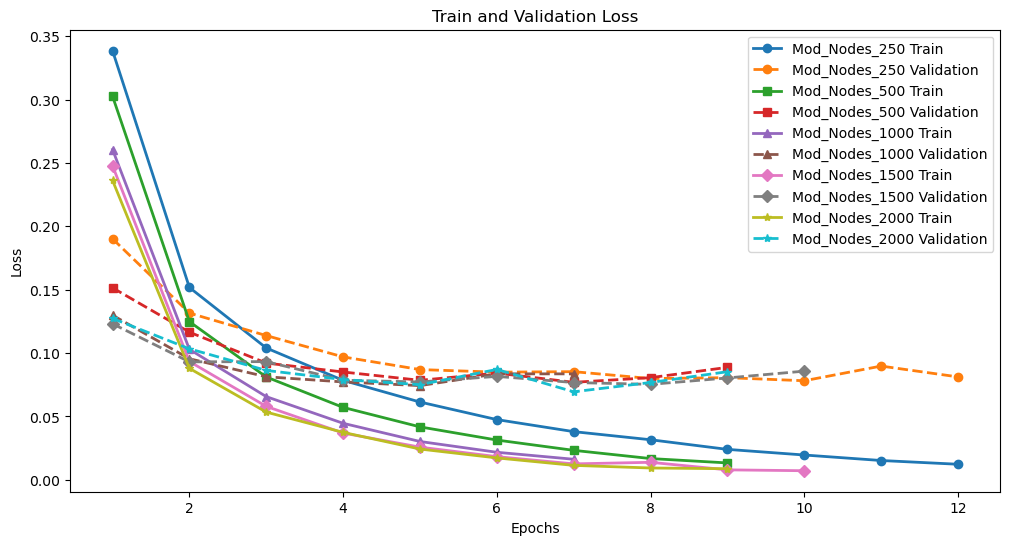

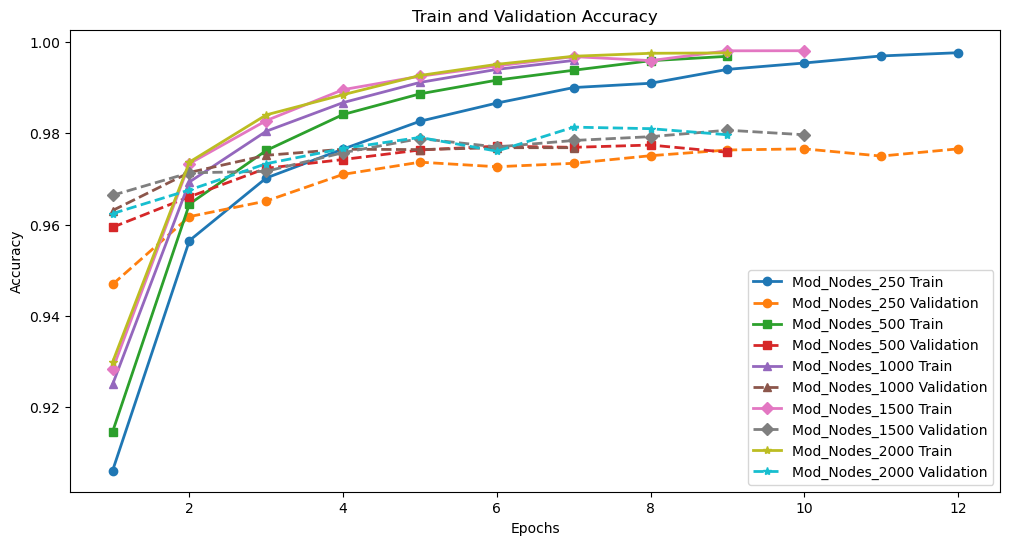

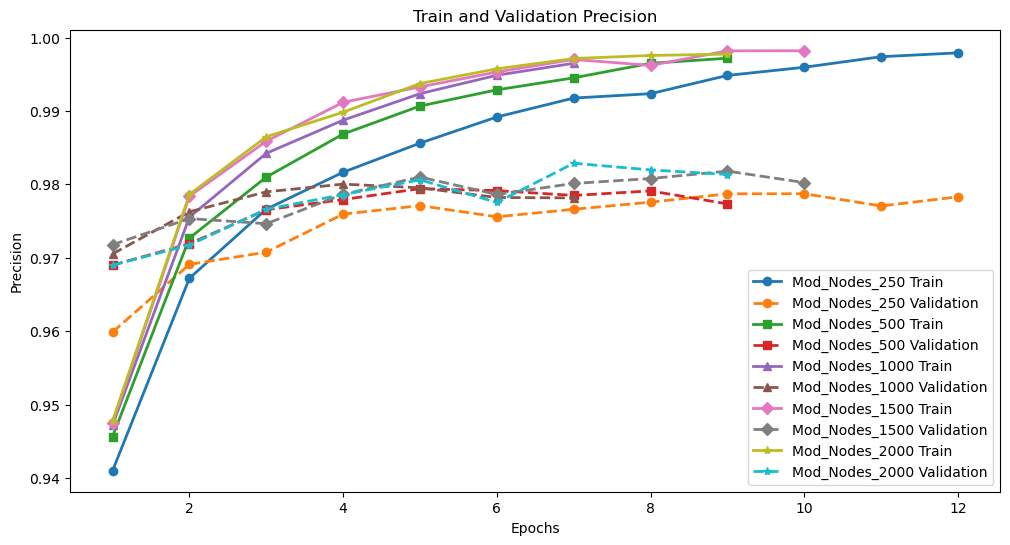

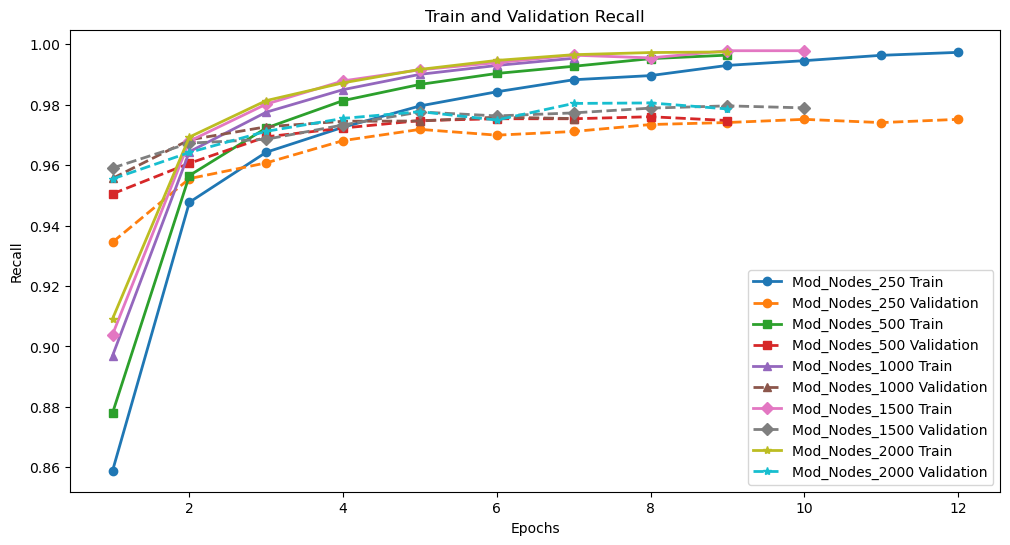

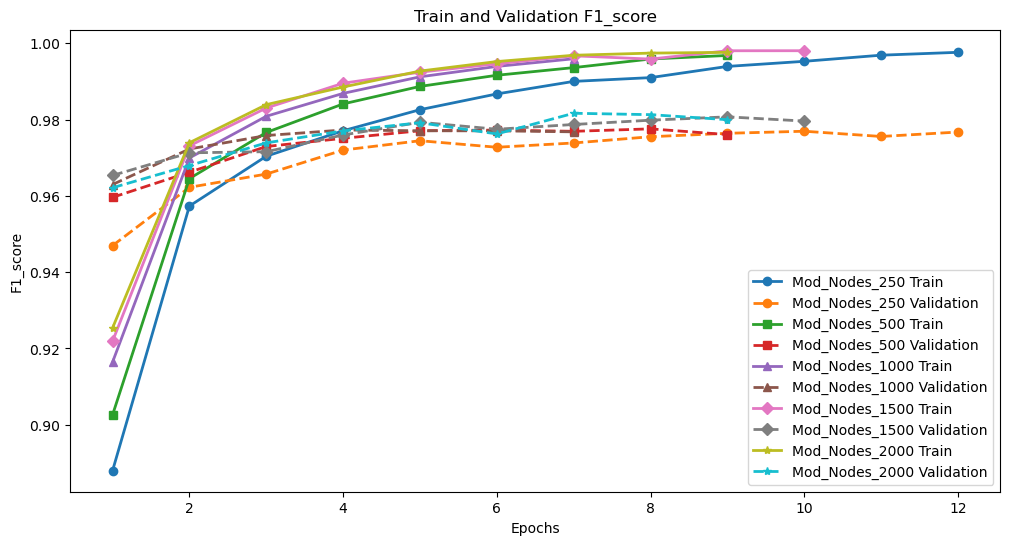

圖片已成功保存到指定目錄中
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
313/313 [==============================] - 0s 946us/step - loss: 0.0657 - accuracy: 0.9800 - precision: 0.9819 - recall: 0.9790 - f1_score: 0.9805
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
313/313 [==============================] - 0s 885us/step - loss: 0.0706 - accuracy: 0.9823 - precision: 0.9827 - recall: 0.9817 - f1_score: 0.9822
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45

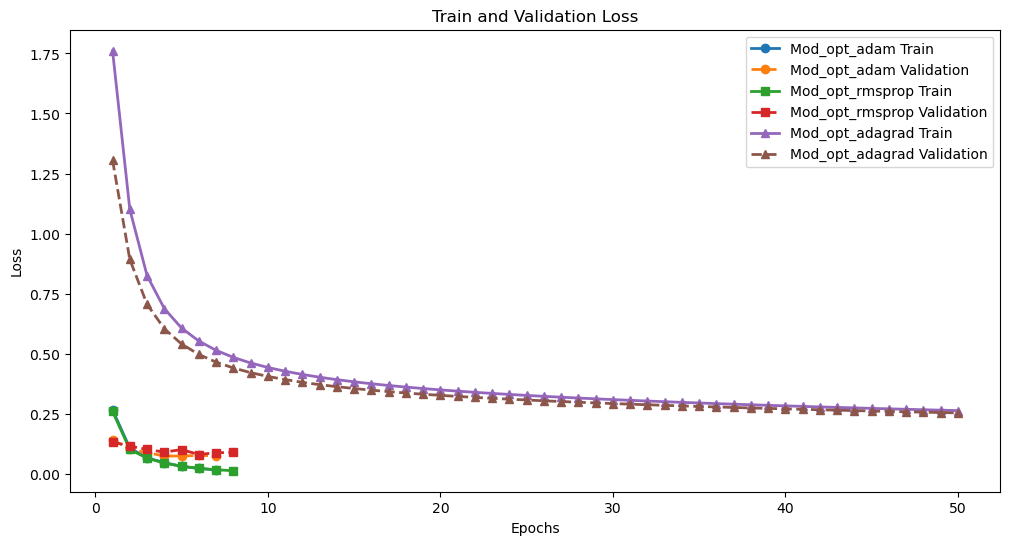

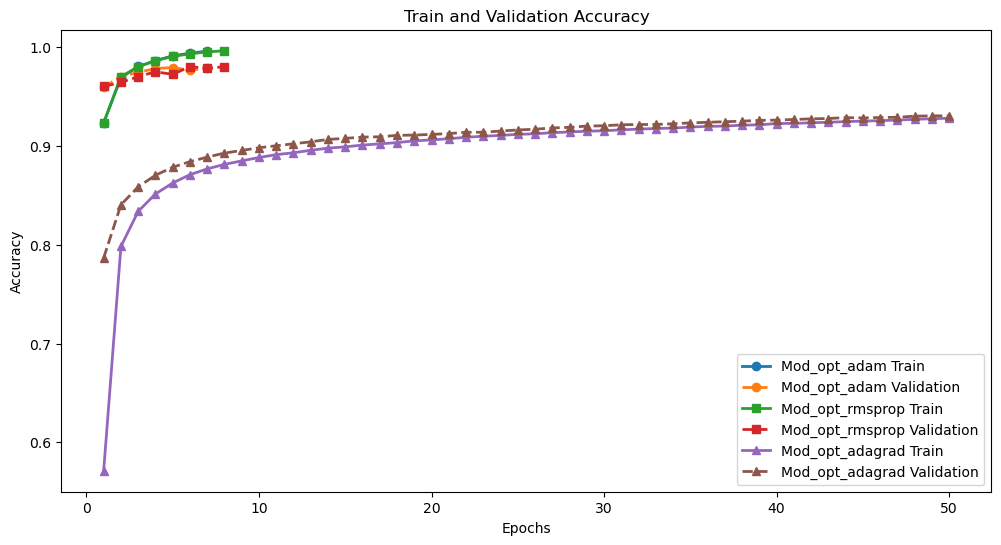

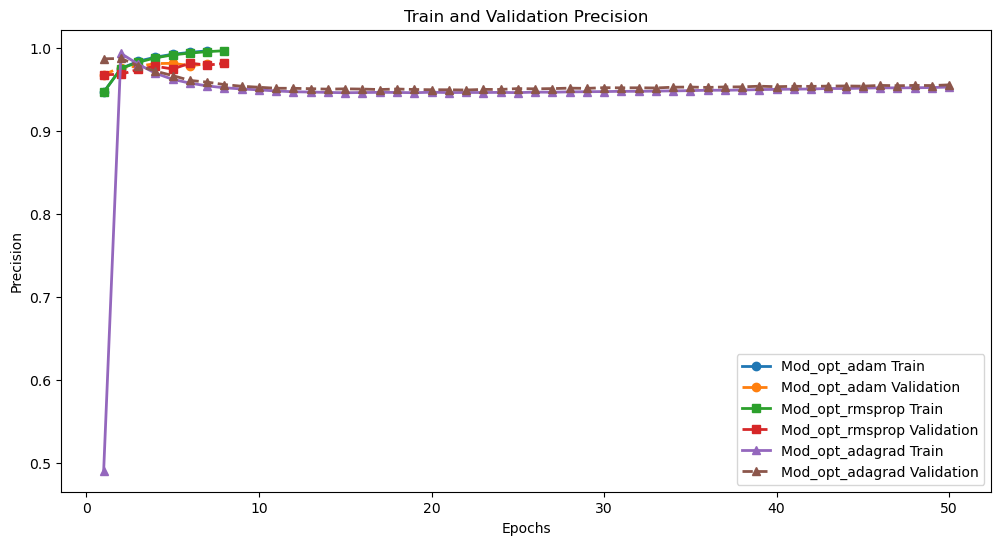

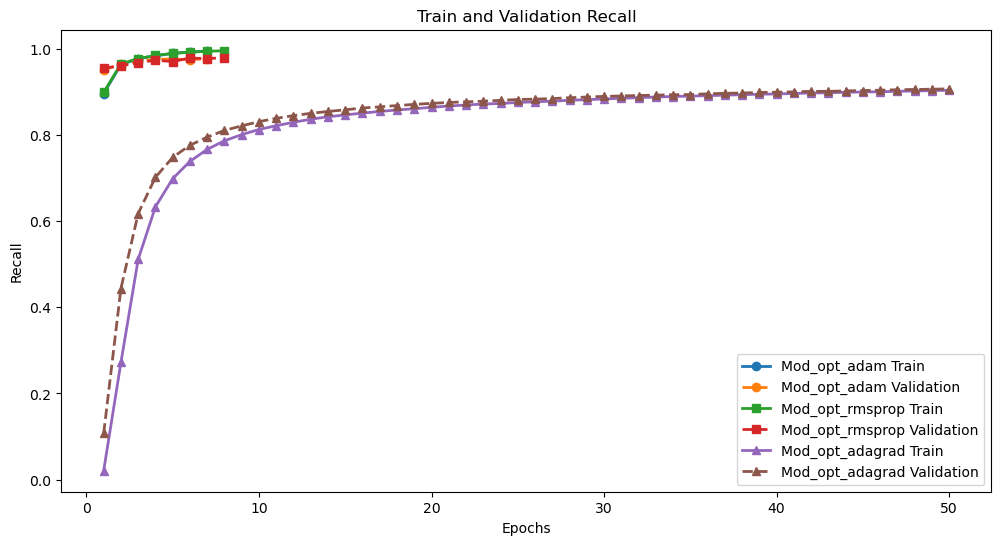

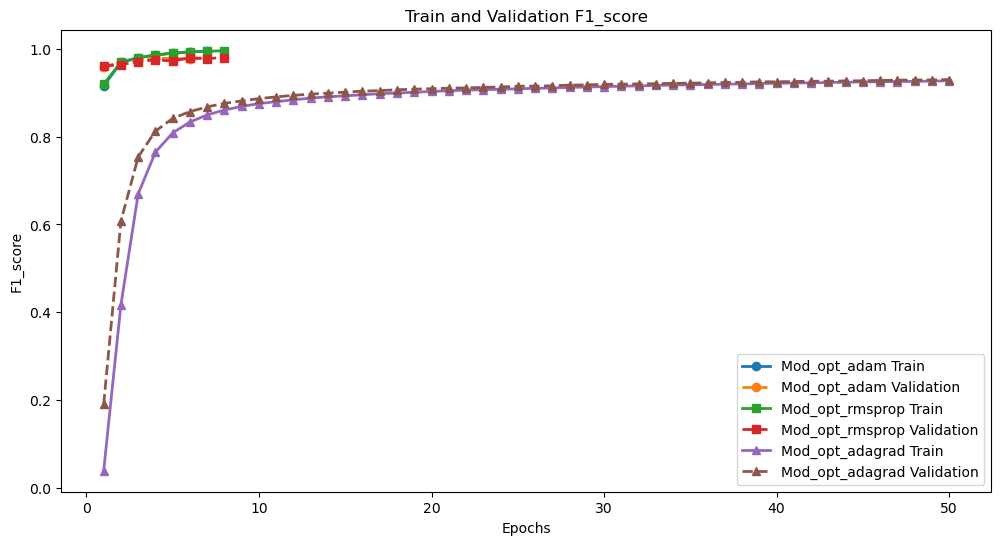

圖片已成功保存到指定目錄中
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
313/313 [==============================] - 0s 866us/step - loss: 0.0619 - accuracy: 0.9821 - precision: 0.9837 - recall: 0.9806 - f1_score: 0.9821
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
313/313 [==============================] - 0s 901us/step - loss: 0.0739 - accuracy: 0.9775 - precision: 0.9791 - recall: 0.9751 - f1_score: 0.9771


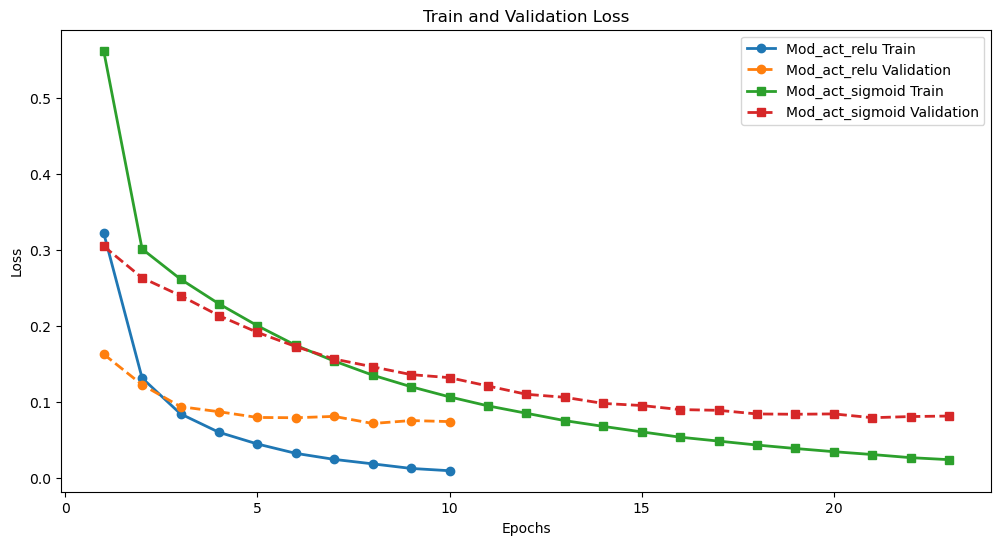

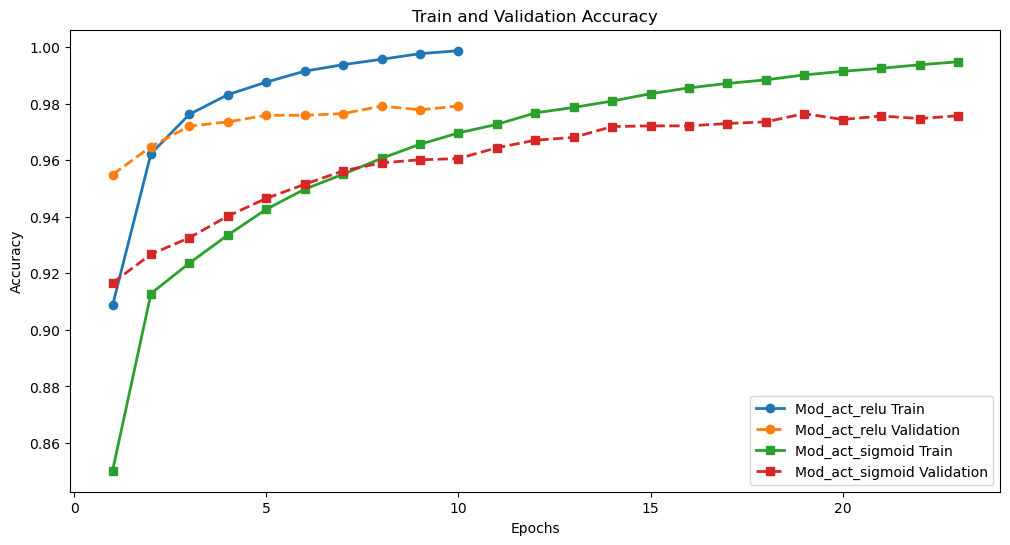

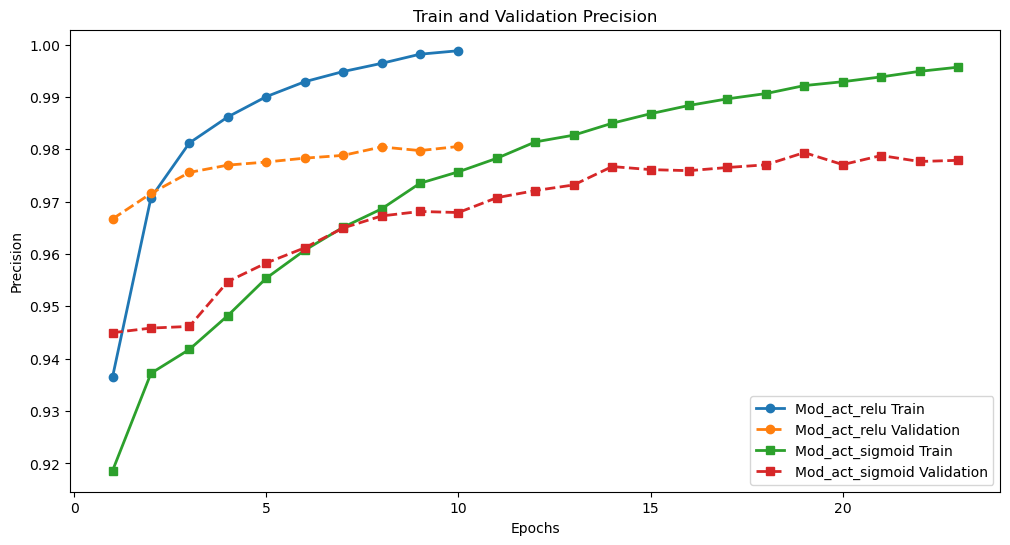

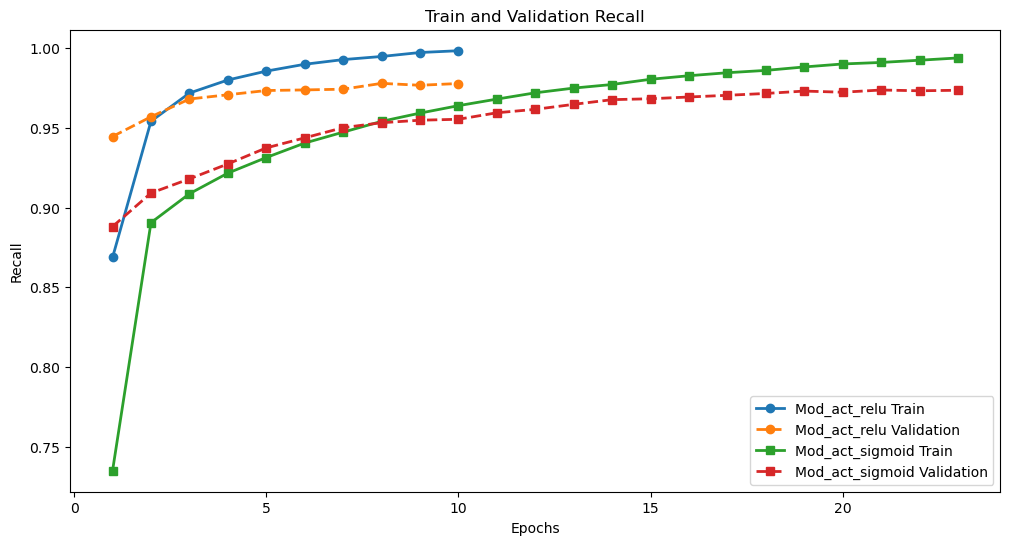

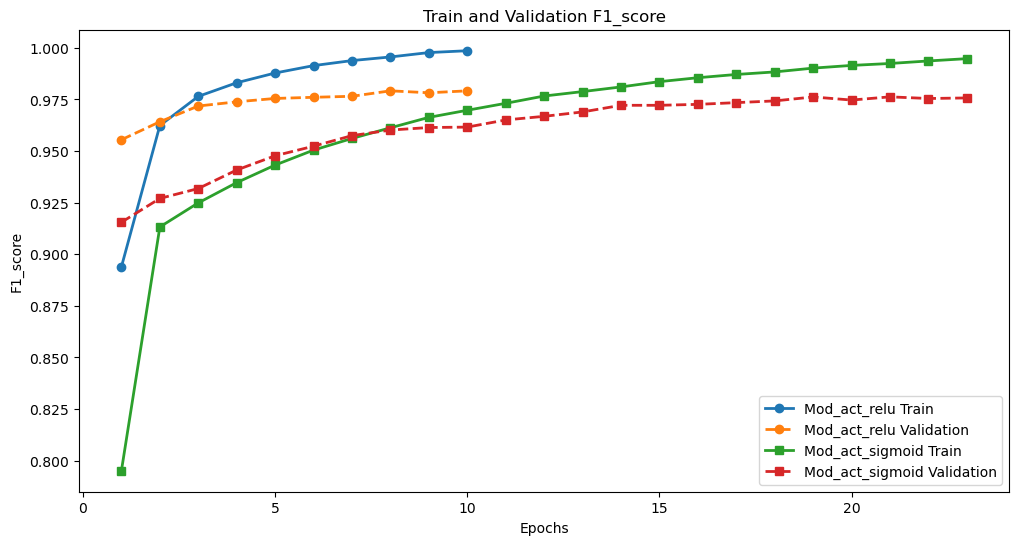

圖片已成功保存到指定目錄中
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
313/313 [==============================] - 0s 888us/step - loss: 0.0676 - accuracy: 0.9800 - precision: 0.9816 - recall: 0.9789 - f1_score: 0.9803
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
313/313 [==============================] - 0s 994us/step - loss: 0.0732 - accuracy: 0.9789 - precision: 0.9806 - recall: 0.9780 - f1_score: 0.9793
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
313/313 [==============================] - 0s 898us/step - loss: 0.0591 - accuracy: 0.9829 - precision: 0.9848 - recall: 0.9817 - f1_score: 0.9832
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
313/313 [==============================] - 0s 891us/step - loss: 0.0641 - accuracy: 0.9810 - precision: 0.9822 

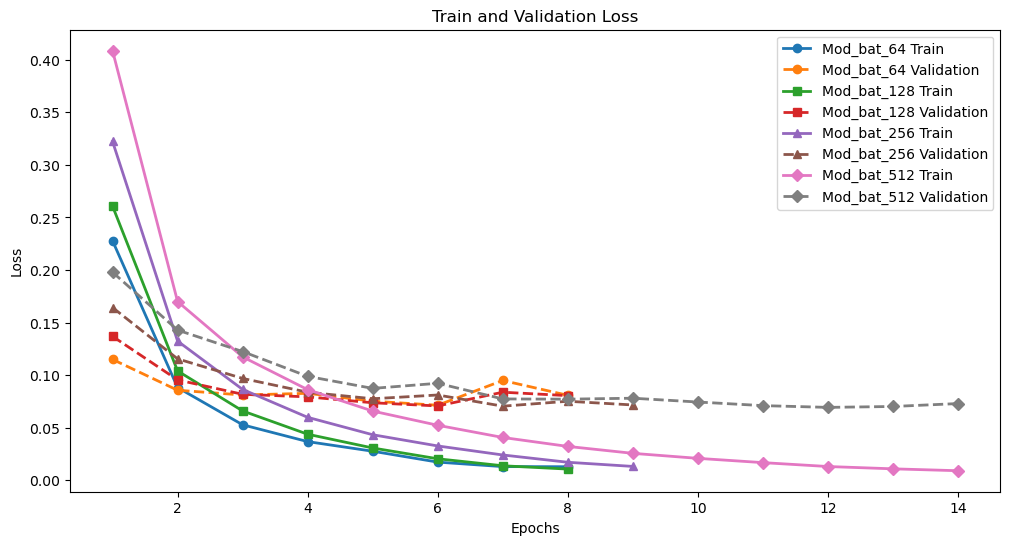

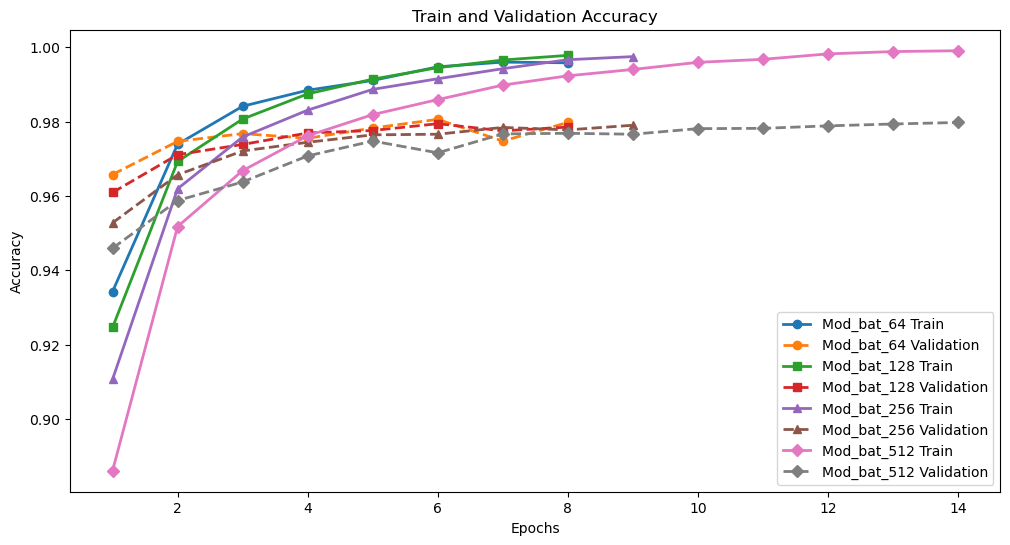

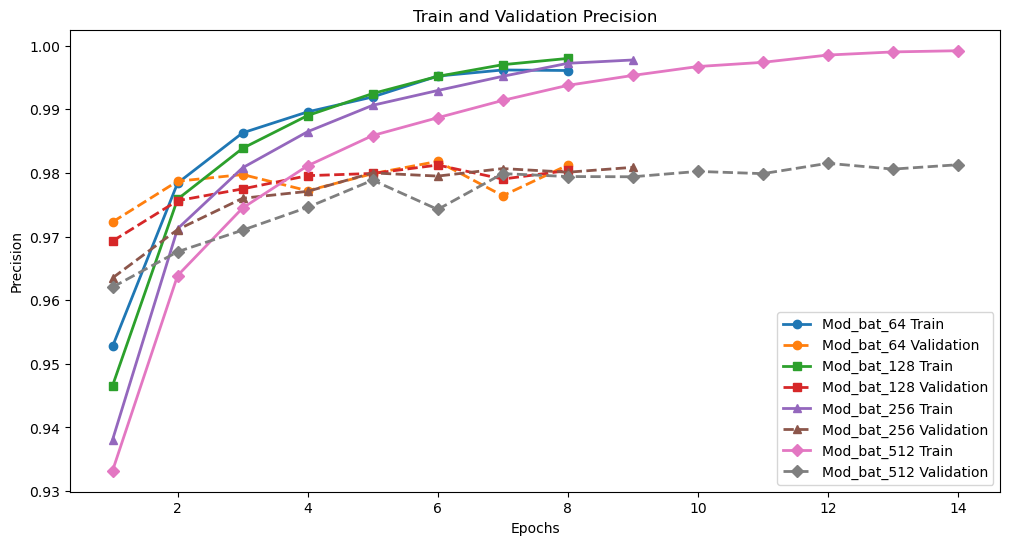

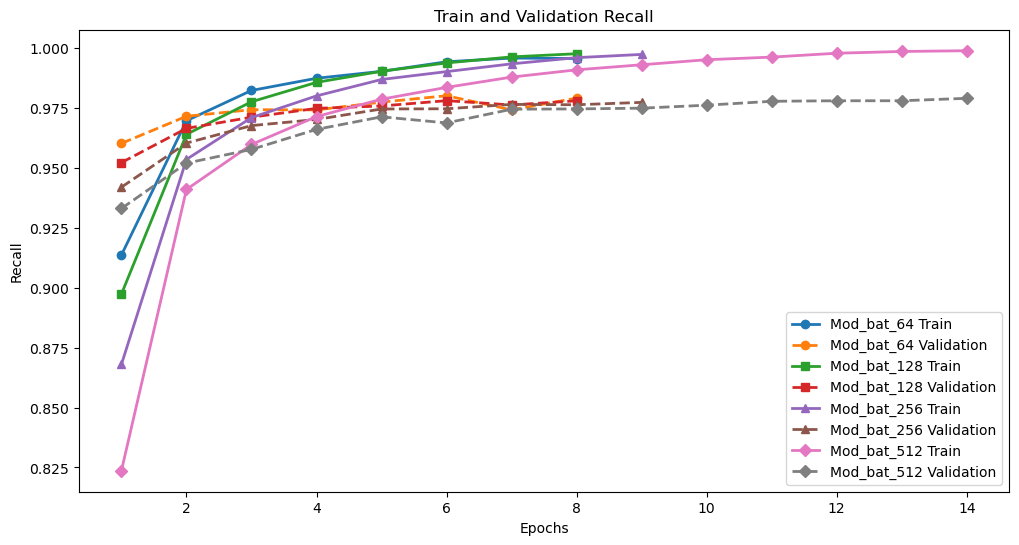

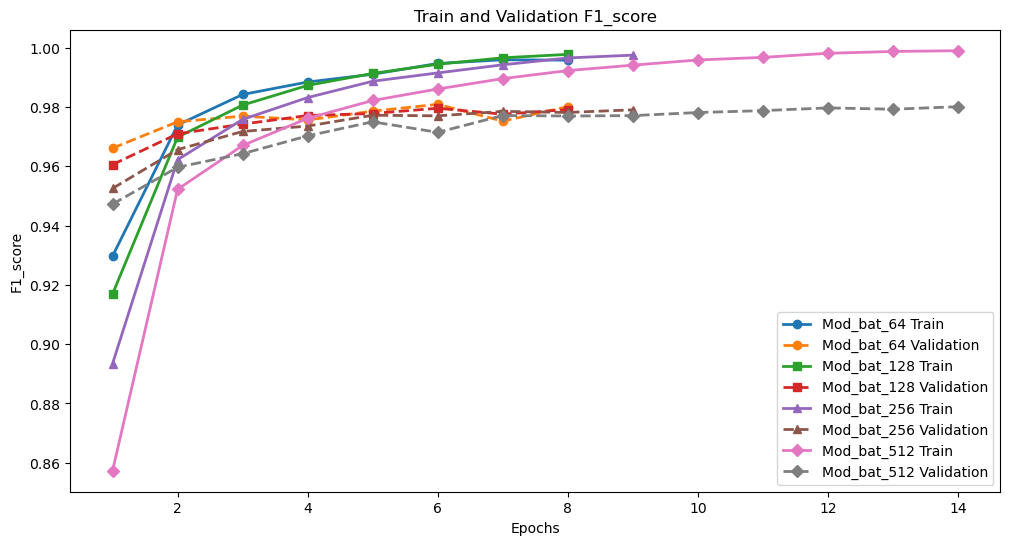

圖片已成功保存到指定目錄中
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
313/313 [==============================] - 0s 1ms/step - loss: 0.0644 - accuracy: 0.9806 - precision: 0.9827 - recall: 0.9787 - f1_score: 0.9807
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
313/313 [==============================] - 0s 1ms/step - loss: 0.0625 - accuracy: 0.9835 - precision: 0.9846 - recall: 0.9828 - f1_score: 0.9837
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
313/313 [==============================] - 0s 1ms/step - loss: 0.0667 - accuracy: 0.9812 - precision: 0.9825 - recall: 0.9808 - f1_score: 0.9816
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
313/313 [==============================] - 1s 2ms/step - loss: 0.0668 - accuracy: 0.9805 - precision: 0.9813 - recall: 0.9799 - f1_score: 0

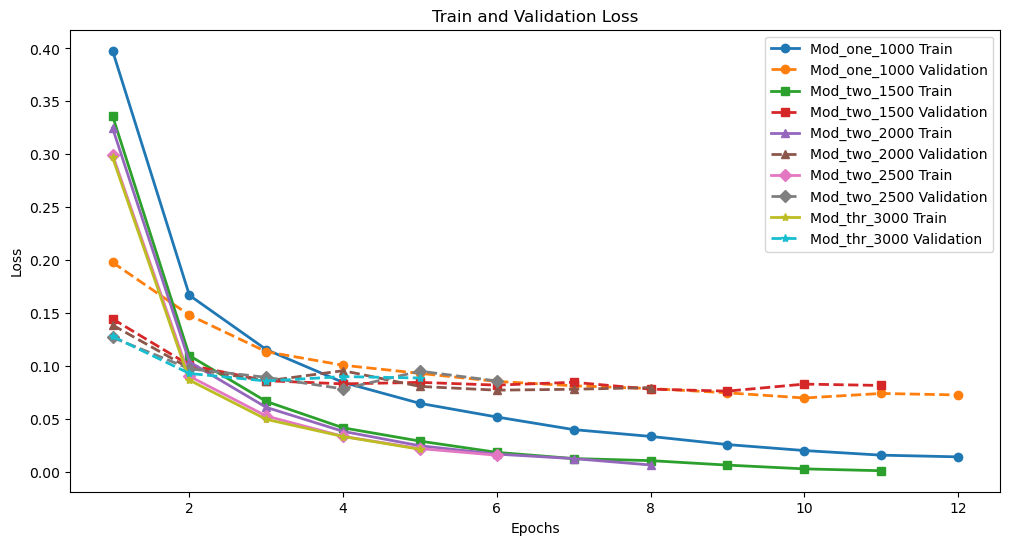

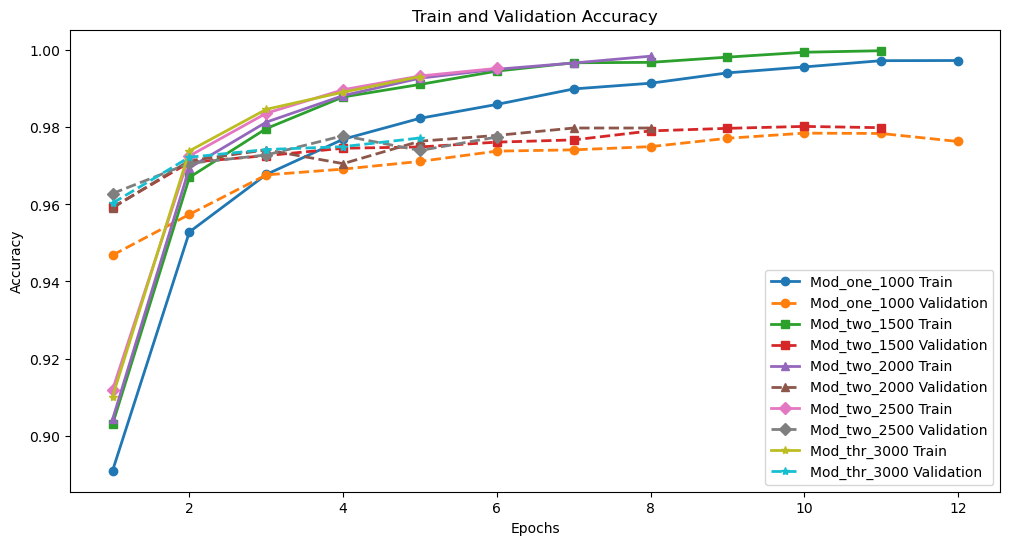

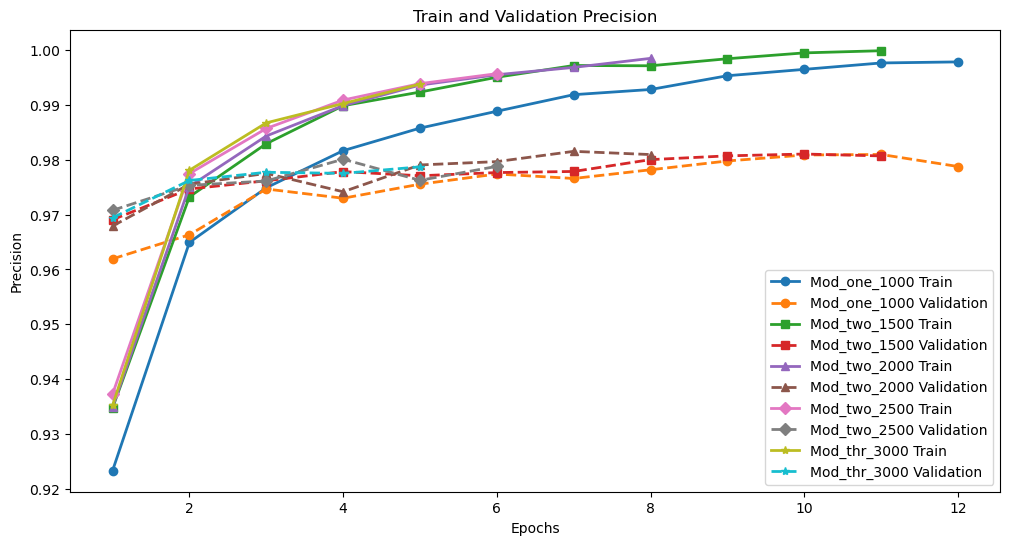

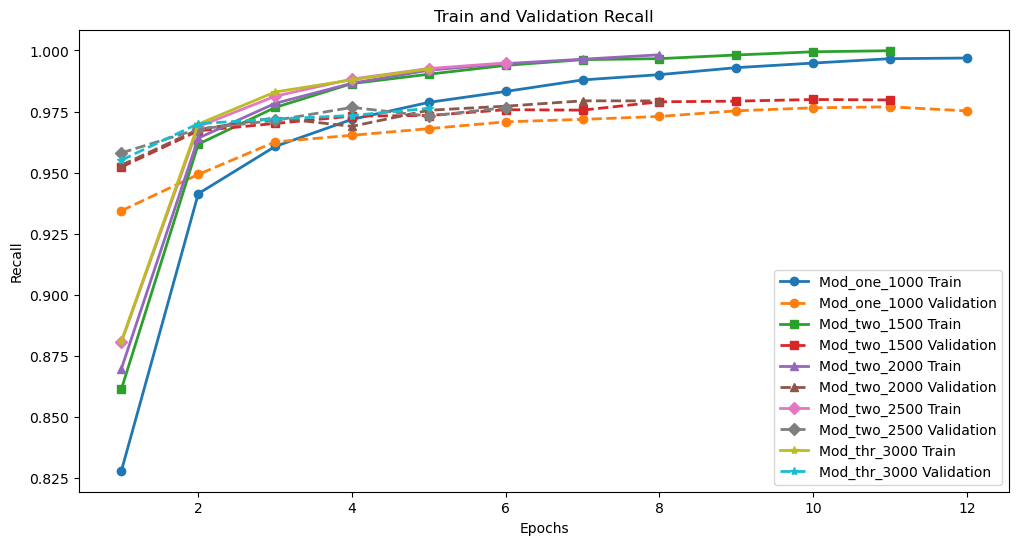

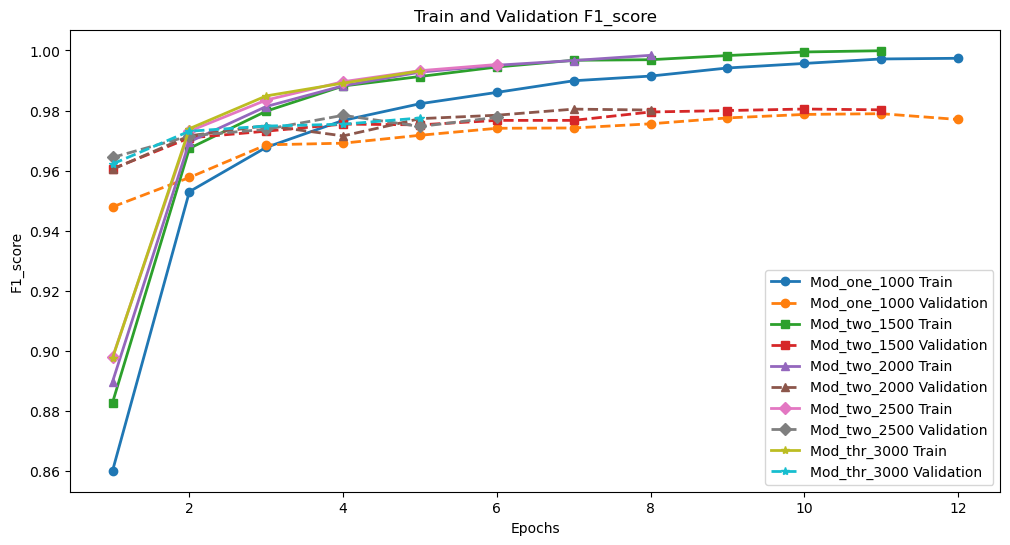

圖片已成功保存到指定目錄中
Data successfully saved to: C:\Users\watch\Desktop\output\data\data_20240402_125601.csv


In [23]:
# 測試
test_models = [nodes_Mod,opt_Mod,act_Mod,bat_Mod]
test_dyn_model = dyn_mod

# 全域變數，控制是否匯出數據
export_data = True

# Initialize variables
all_models_performances = []
processed_models = set()  # To avoid re-running models

# Function to check if the model has been processed
def check_if_processed(model_name):
    return model_name in processed_models

# Function to process models
def process_models(model_df, dynamic=False):
    all_train_histories = []
    model_names = []
    all_test_performances = []

    for index, mod_hpy in model_df.iterrows():
        # Check if model has been processed
        if check_if_processed(mod_hpy['model_name']):
            continue  # Skip this iteration if model already processed
        
        # Process model based on dynamic flag
        if dynamic:
            model_name, train_history, test_performance = dynamic_MLP_constructor(mod_hpy)
        else:
            model_name, train_history, test_performance = modified_MLP_NN(mod_hpy)
        
        # Update records
        processed_models.add(model_name)
        all_train_histories.append(train_history)
        model_names.append(model_name)
        all_test_performances.append([model_name] + list(test_performance))
    
    # Plot and return performances
    plot_metrics_test(all_train_histories, model_names)
    return pd.DataFrame(all_test_performances, columns=['model_name','Loss', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Process static models
for model_df in test_models:
    test_df = process_models(model_df)
    all_models_performances.append(test_df)

# Process dynamic models
dyn_test_df = process_models(test_dyn_model, dynamic=True)
all_models_performances.append(dyn_test_df)

# Data export logic
if export_data:
    combined_df = pd.concat(all_models_performances, ignore_index=True)
    output_folder = 'C:\\Users\\watch\\Desktop\\output\\data'

    # Ensure output directory exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Generate output file path
    current_time = time.strftime("%Y%m%d_%H%M%S")
    output_file_path = os.path.join(output_folder, f"data_{current_time}.csv")
    
    # Save data
    combined_df.to_csv(output_file_path, index=False)
    print(f"Data successfully saved to: {output_file_path}")